# Mise en place du code 

Packages et fonctions utiles par la suite

In [2]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import tkinter as tk
from tkinter import messagebox, scrolledtext
import os
import pandas as pd
from openpyxl import load_workbook
import re

# Courbe de calibration angle → énergie normalisée
def calib(x):
    angle = np.arange(80, 311, 10)
    OD1 = 1 / 0.10669 ; OD2 = 10**2.46
    energies5 = np.array([1.06, 1.56, 2.29, 3.31, 4.83, 7.01, 10.2, 14.8, 21.5, 31.0, 44.1])
    energies5_1 = (44.1 / 4.47) * np.array([6.2, 8.39, 11.0, 14.5, 18.7, 24.4, 32.0, 41.8, 53.7, 54.3, 54.1, 54.1, 53.9])
    energies5 = np.append(energies5, energies5_1)
    energies5 /= np.max(energies5)
    return interp1d(angle, energies5, kind='cubic')(x)

# Lissage d’un signal avec un filtre de Savitzky-Golay
def smooth(x, S_value):
    if S_value < 3:
        raise ValueError("Smoothing factor must be ≥ 3.")
    if S_value % 2 == 0:
        raise ValueError("Smoothing factor must be odd.")
    return savgol_filter(x, S_value, 3)

# Calcul de la largeur à mi-hauteur (FWHM) d’un signal
def fwhm(x, y):
    y = y / np.max(y)
    N = len(y)
    lev50 = 0.5
    center = np.argmax(y) if y[0] < lev50 else np.argmin(y)
    i = 1
    while i < N and np.sign(y[i] - lev50) == np.sign(y[i-1] - lev50): i += 1
    if i < N:
        interp = (lev50 - y[i-1]) / (y[i] - y[i-1])
        tlead = x[i-1] + interp * (x[i] - x[i-1])
        i = center + 1
        while i < N and np.sign(y[i] - lev50) == np.sign(y[i-1] - lev50): i += 1
        if i != N:
            interp = (lev50 - y[i-1]) / (y[i] - y[i-1])
            ttrail = x[i-1] + interp * (x[i] - x[i-1])
            return ttrail - tlead
    return np.nan

# Extraction du premier nombre (entier ou décimal) d'une chaîne
def find_decimal_number(input_string):
    match = re.search(r'[-+]?\d*\.\d+|\d+', input_string)
    return float(match.group()) if match else None

# Mise en place des énergies du laser 

La première partie du codes permet de déterminer toutes les énergies que l'on va envoyer sur l'échantillon au cours de la manip d'ASE

In [3]:
# Paramètres mesurés et corrections optiques
OD1_measured = 1.004277065504523
t_OD2_measured = 53.0 / 0.392
transmission_wheelat280_lens = 0.959
t_OD3 = 1076.3401937639617

# Énergie maximale délivrée (en nJ)
energy_max = 24 * t_OD3 * transmission_wheelat280_lens
print(energy_max)

# Paramètres angulaires
angle_start = 85  # en degrés
angle_stop = 280
number_points = 50

# Génération des angles et calculs des énergies associées
angles = np.logspace(np.log10(angle_start), np.log10(angle_stop), num=number_points)
transmissions = calib(angles)
energies = energy_max * transmissions

# Affichage des angles utilisés
for i, angle in enumerate(angles):
    print(f"{i + 1} : {angle:.2f}")

# Sauvegarde des énergies calculées
np.savetxt('energies.txt', energies, header='Measured energies in nJ')

24773.04589967134
1 : 85.00
2 : 87.09
3 : 89.24
4 : 91.44
5 : 93.69
6 : 96.00
7 : 98.36
8 : 100.78
9 : 103.26
10 : 105.81
11 : 108.41
12 : 111.08
13 : 113.82
14 : 116.62
15 : 119.49
16 : 122.44
17 : 125.45
18 : 128.54
19 : 131.71
20 : 134.95
21 : 138.27
22 : 141.68
23 : 145.17
24 : 148.74
25 : 152.41
26 : 156.16
27 : 160.01
28 : 163.95
29 : 167.98
30 : 172.12
31 : 176.36
32 : 180.70
33 : 185.15
34 : 189.71
35 : 194.39
36 : 199.17
37 : 204.08
38 : 209.11
39 : 214.25
40 : 219.53
41 : 224.94
42 : 230.48
43 : 236.15
44 : 241.97
45 : 247.93
46 : 254.04
47 : 260.29
48 : 266.70
49 : 273.27
50 : 280.00


# Smooth des courbes

Partie qui sert a faire un smooth des courbes afin d'enlever les pics parasites

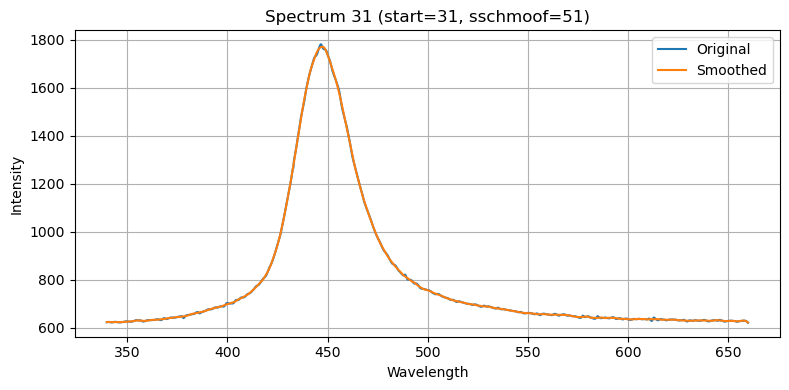

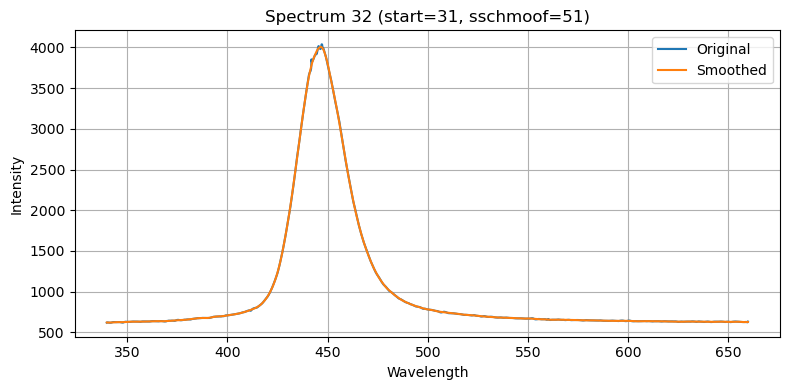

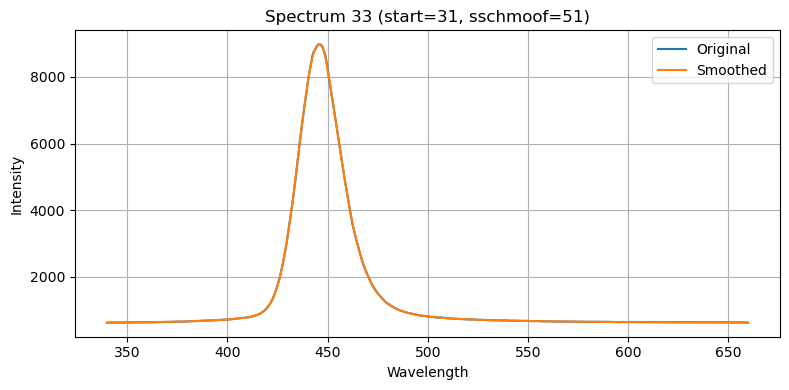

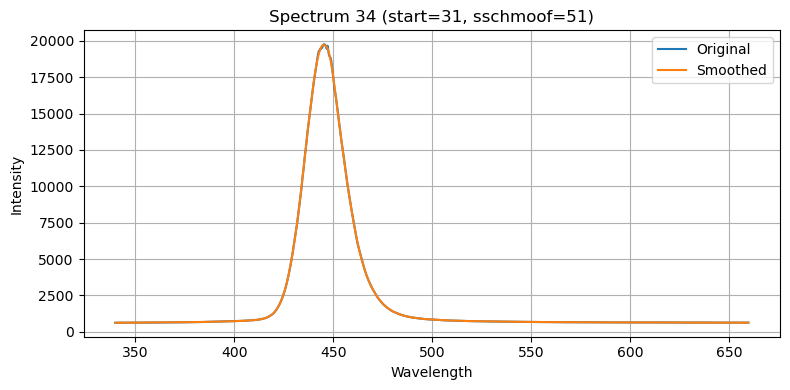

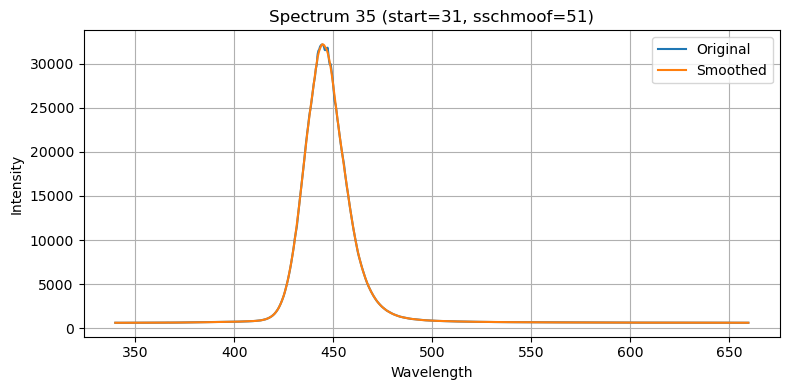

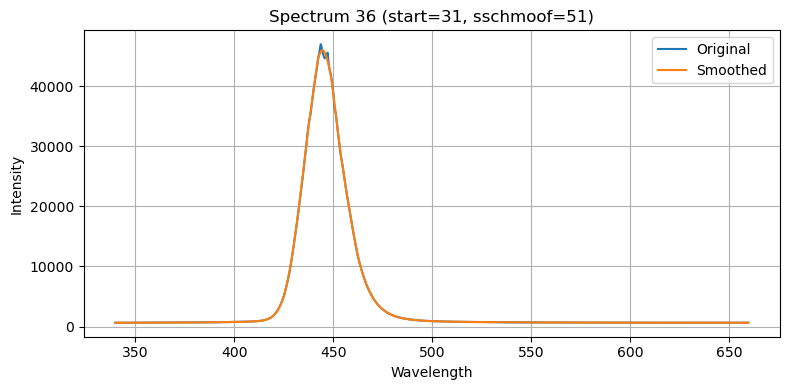

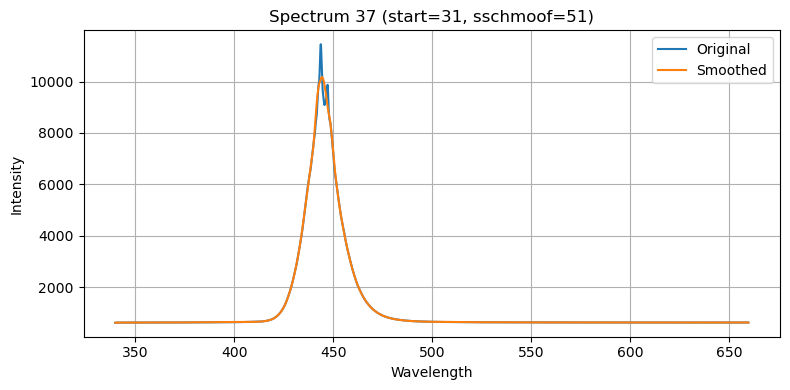

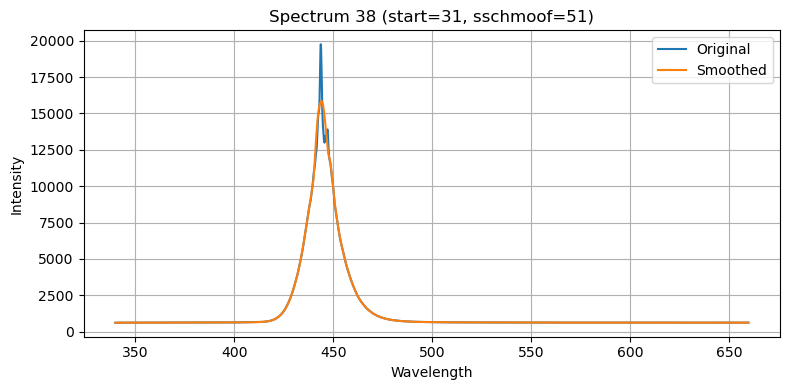

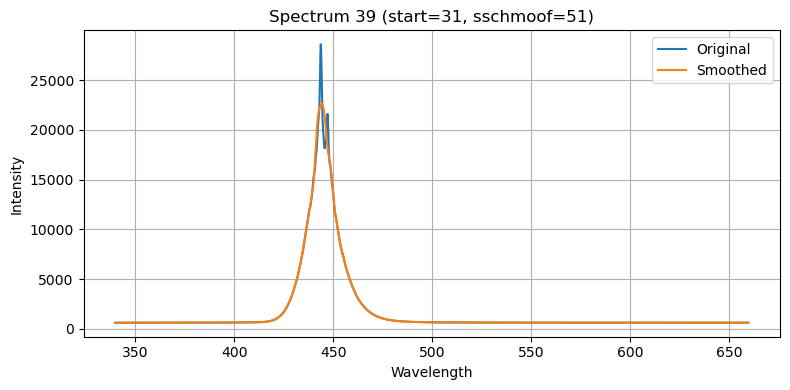

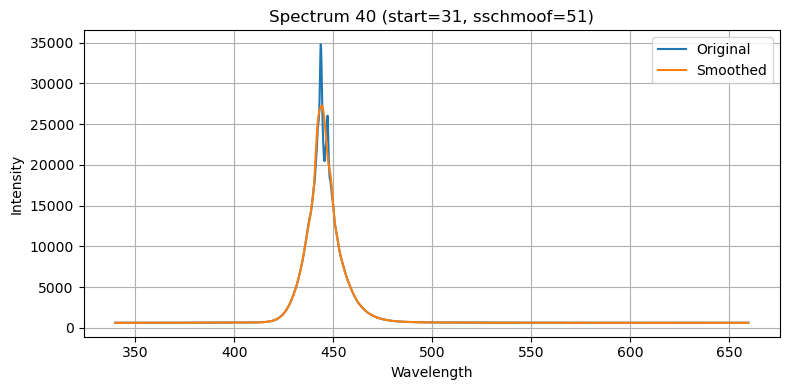

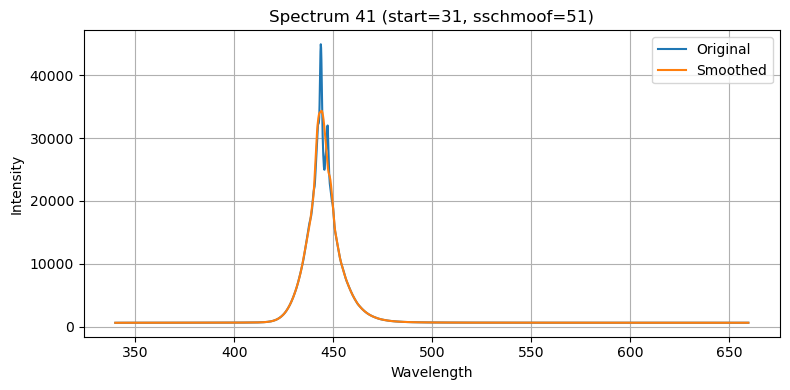

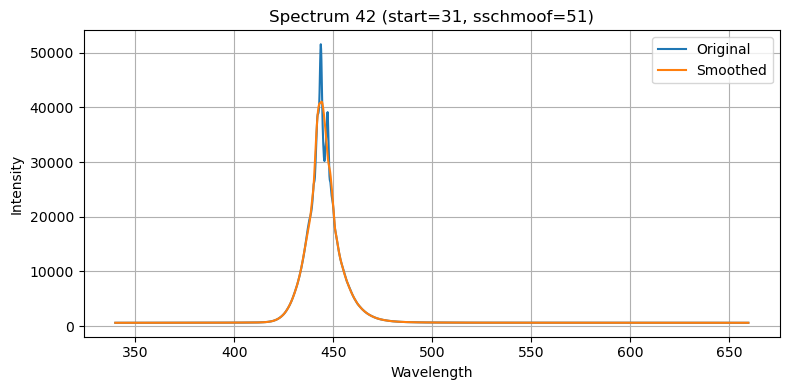

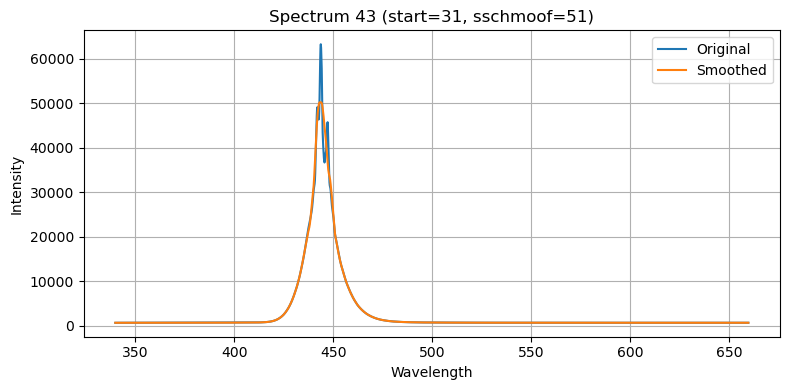

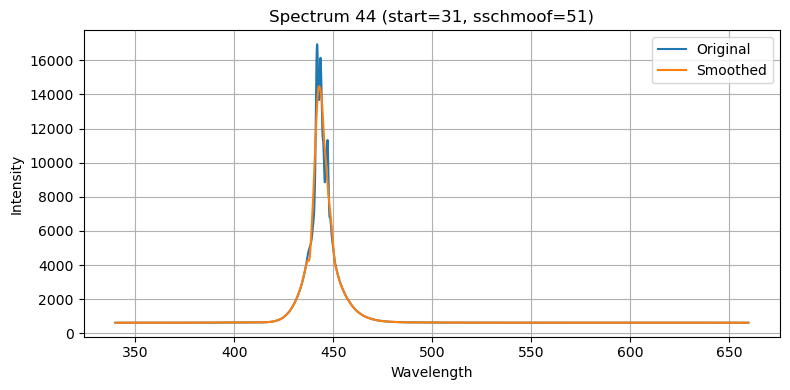

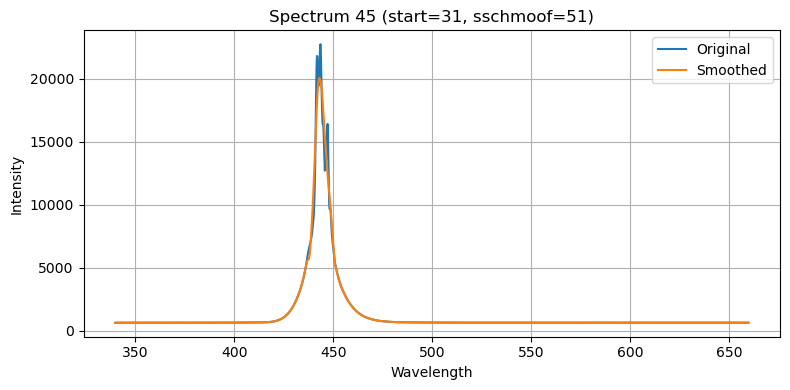

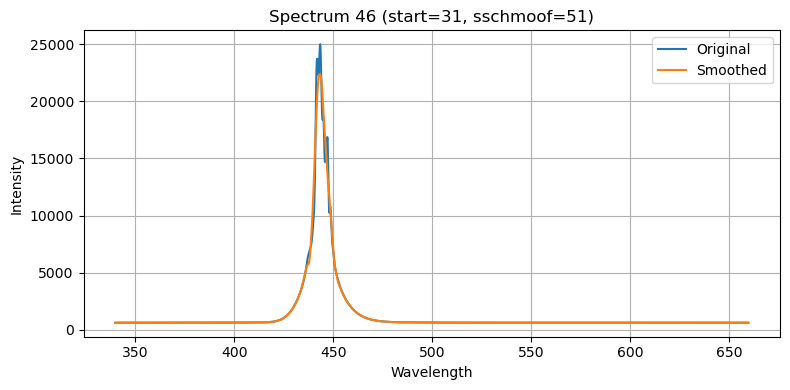

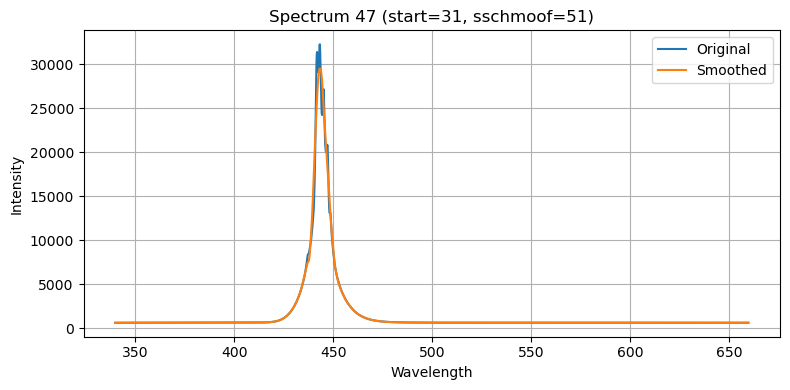

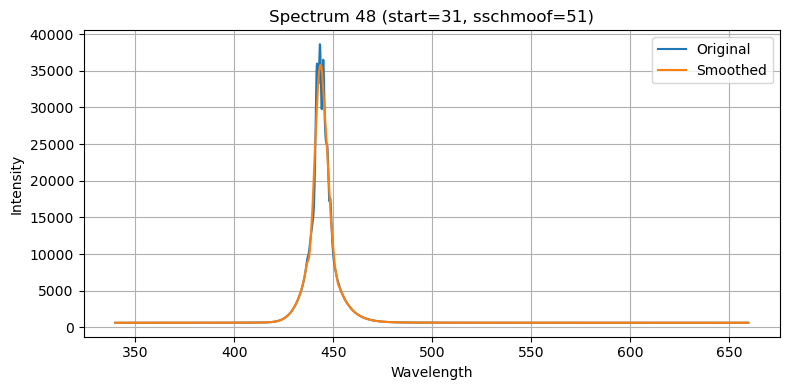

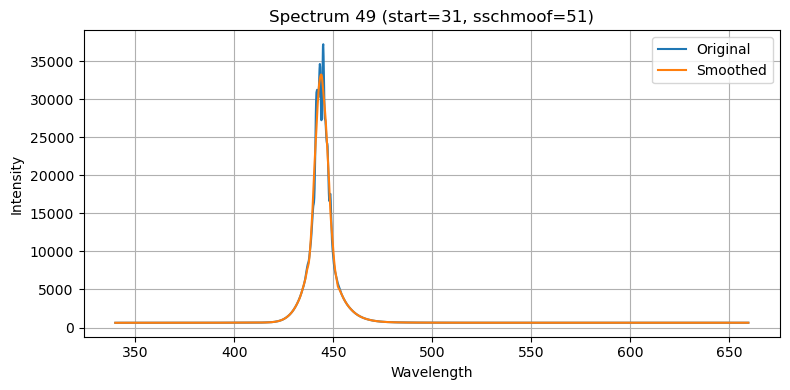

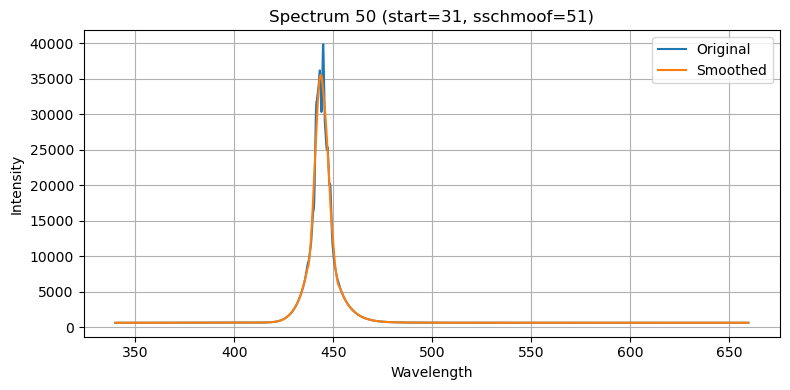

In [6]:
start = 31         # Lisser les spectres à partir de celui-ci
sschmoof = 51    # Paramètre de lissage impair ≥ 3

# === Paramètres de découpage spectre (uniquement pour le smooth) ===
lambda_min = None  # Exemple : 500  (en nm) ou None pour ignorer
lambda_max = None  # Exemple : 700  (en nm) ou None pour ignorer

data_dir = os.path.join(os.getcwd(), 'A', 'B', 'C')
results_dir = os.path.join(os.getcwd(), 'ASE Results')
os.makedirs(results_dir, exist_ok=True)

files = sorted([f for f in os.listdir(data_dir) if f.startswith('spectrum_') and f.endswith('.txt')])
number_points = len(files)

raw_file = os.path.join(results_dir, 'raw_spectra.txt')
smooth_file = os.path.join(results_dir, 'smoothed_data.txt')

# Chargement du 1er spectre pour récupérer les longueurs d'onde
first_data = np.loadtxt(os.path.join(data_dir, files[0]))
wavelength_all = first_data[:, 0]

# Masque pour le découpage uniquement utilisé pour le smooth
lambda_mask = np.ones_like(wavelength_all, dtype=bool)
if lambda_min is not None:
    lambda_mask &= wavelength_all >= lambda_min
if lambda_max is not None:
    lambda_mask &= wavelength_all <= lambda_max

wavelength_raw = wavelength_all
wavelength_smooth = wavelength_all[lambda_mask]

num_points_raw = len(wavelength_raw)
num_points_smooth = len(wavelength_smooth)

# Vérifie et supprime les fichiers obsolètes si la taille ne correspond pas
if os.path.exists(raw_file):
    try:
        tmp = np.loadtxt(raw_file)
        if tmp.shape[0] != num_points_raw:
            print("⚠️ Suppression de raw_spectra.txt (taille incompatible)")
            os.remove(raw_file)
    except Exception as e:
        print(f"Erreur lecture {raw_file} : {e}")
        os.remove(raw_file)

if os.path.exists(smooth_file):
    try:
        tmp = np.loadtxt(smooth_file)
        if tmp.shape[0] != num_points_smooth:
            print("⚠️ Suppression de smoothed_data.txt (taille incompatible)")
            os.remove(smooth_file)
    except Exception as e:
        print(f"Erreur lecture {smooth_file} : {e}")
        os.remove(smooth_file)

# Création ou chargement des matrices
if os.path.exists(raw_file) and os.path.exists(smooth_file):
    raw_matrix = np.loadtxt(raw_file)
    smooth_matrix = np.loadtxt(smooth_file)
else:
    raw_matrix = np.zeros((num_points_raw, number_points + 1))
    smooth_matrix = np.zeros((num_points_smooth, number_points + 1))
    raw_matrix[:, 0] = wavelength_raw
    smooth_matrix[:, 0] = wavelength_smooth

# Boucle de traitement
for idx, fname in enumerate(files, 1):
    filepath = os.path.join(data_dir, fname)
    data = np.loadtxt(filepath)
    full_spectrum = data[:, 1]
    
    # Remplir raw (non filtré)
    raw_matrix[:, idx] = full_spectrum

    # Filtrage pour le smooth
    spectrum_for_smooth = full_spectrum[lambda_mask]

    if idx < start and np.any(smooth_matrix[:, idx] != 0):
        pass  # Conserver ancienne version
    else:
        spectrum_smooth = smooth(spectrum_for_smooth, sschmoof)
        smooth_matrix[:, idx] = spectrum_smooth

    # Affichage individuel lissé uniquement à partir de `start`
    if idx >= start:
        plt.figure(figsize=(8, 4))
        plt.plot(wavelength_smooth, spectrum_for_smooth, label='Original')
        plt.plot(wavelength_smooth, smooth_matrix[:, idx], label='Smoothed')
        plt.title(f'Spectrum {idx:02d} (start={start}, sschmoof={sschmoof})')
        plt.xlabel('Wavelength')
        plt.ylabel('Intensity')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Sauvegardes
header = 'wavelength ' + ' '.join([f'spectrum_{i:02d}' for i in range(1, number_points + 1)])
np.savetxt(raw_file, raw_matrix, header=header)
np.savetxt(smooth_file, smooth_matrix, header=header)

# Tracé final des spectres normalisés - bruts
plt.figure(figsize=(12, 6))
for i in range(number_points):
    norm_spec = (raw_matrix[:, i+1] - np.min(raw_matrix[:, i+1])) / np.max(raw_matrix[:, i+1]- np.min(raw_matrix[:, i+1]))
    plt.plot(wavelength_raw, norm_spec)
plt.title('Raw spectra image')
plt.xlabel('Wavelength')
plt.ylabel('Normalized intensity')
plt.grid(True)
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)
plt.savefig(os.path.join(results_dir, 'raw_spectra_image.png'))
plt.close()

# Tracé final des spectres normalisés - lissés
plt.figure(figsize=(12, 6))
for i in range(number_points):
    norm_spec = (smooth_matrix[:, i+1] - np.min(smooth_matrix[:, i+1])) / np.max(smooth_matrix[:, i+1]- np.min(smooth_matrix[:, i+1]))
    plt.plot(wavelength_smooth, norm_spec)
plt.title('Smoothed spectra image')
plt.xlabel('Wavelength')
plt.ylabel('Normalized intensity')
plt.grid(True)
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)
plt.savefig(os.path.join(results_dir, 'smoothed_spectra_image.png'))
plt.close()



# Courbe d'ASE 

Code final qui donne la courbe d'ASE 

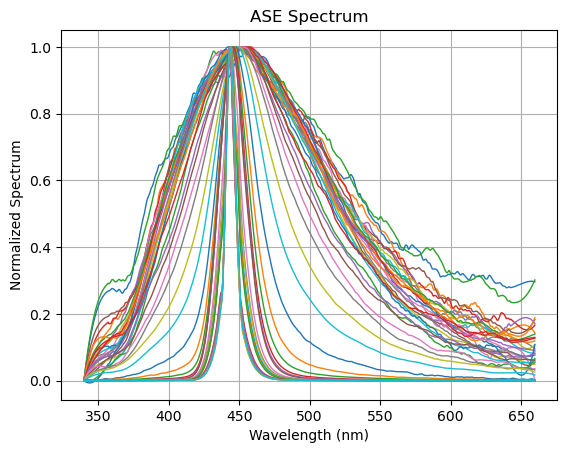

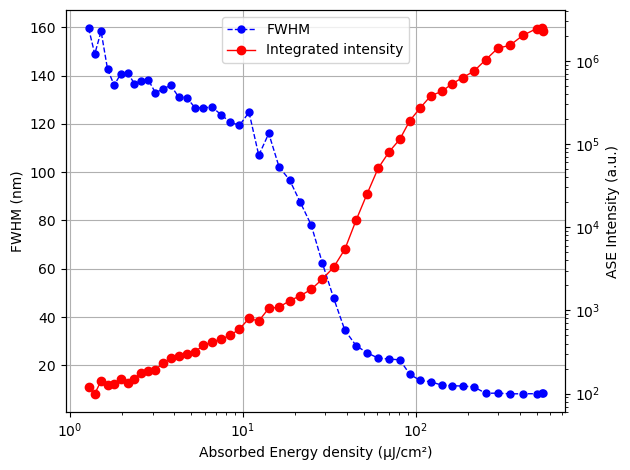

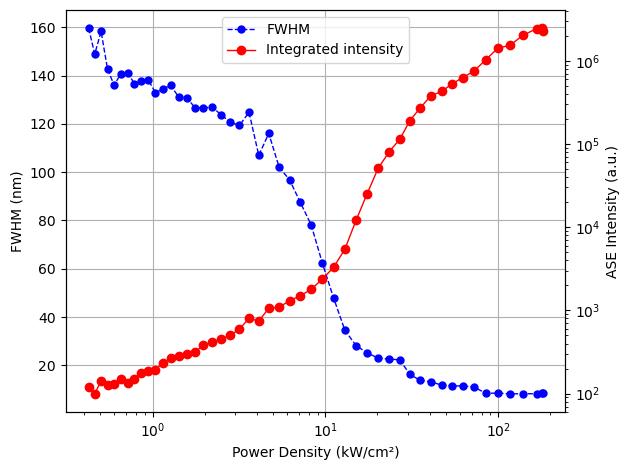

In [8]:
# ========== Chargement données manuelles & Excel ==========
Dir_ASE = os.getcwd()
excel_file = os.path.join(Dir_ASE, 'Manual_ASE_data.xlsx')

df = pd.read_excel(excel_file, header=None)
Manual_Data = df.iloc[:8, 0].values
df_data = pd.read_excel(excel_file, skiprows=8)
energy_time = df_data.values

data_ASE = energy_time[:, 1]
Measured_Incident_Energy_nanojoules = np.loadtxt('energies.txt', skiprows=1)
Integration_Time_ASE = energy_time[:, 4]
ODs = energy_time[:, 2]
Ods_spectro = energy_time[:, 3]
Repetition_rate = energy_time[:, 5]

number_of_pulses = Integration_Time_ASE * Repetition_rate

PulseDuration = find_decimal_number(Manual_Data[2]) * 1e-9
PumpWavelength = find_decimal_number(Manual_Data[1]) * 1e-9
Absorption = find_decimal_number(Manual_Data[3])
L_stripe = find_decimal_number(Manual_Data[4]) * 1e-4
e_stripe = find_decimal_number(Manual_Data[5]) * 1e-4

Measured_Incident_Energy_nanojoules *= 1 / (10 ** -ODs)
Incident_Energy_microjoules = 1e-3 * Measured_Incident_Energy_nanojoules
Absorbed_Energy_Joules = Incident_Energy_microjoules * 1e-6 * Absorption
EnergyDensity = Absorbed_Energy_Joules / (L_stripe * e_stripe)
EnergyDensity_microJoules_per_cm2 = 1e6 * EnergyDensity
PowerDensity = EnergyDensity / PulseDuration

# ========== Chargement des spectres lissés ==========
results_dir = os.path.join(Dir_ASE, 'ASE Results')
os.makedirs(results_dir, exist_ok=True)

smooth_file = os.path.join(results_dir, 'smoothed_data.txt')
data_smooth = np.loadtxt(smooth_file, skiprows=1)

Lambda = data_smooth[:, 0]
deltaLambda = np.abs(np.mean(np.diff(Lambda)))

length_of_spectrum = Lambda.size
Spectrum = np.zeros((length_of_spectrum, len(data_ASE)))

for i in range(len(data_ASE)):
    idx = int(data_ASE[i]) - 1
    Spectrum[:, i] = data_smooth[:, idx + 1] / number_of_pulses[i]

# ========== Calcul FWHM et intensité intégrée ==========
ASEintensity = []
Fw = np.zeros(len(data_ASE))

for i in range(len(data_ASE)):
    Spectrum[:, i] = Spectrum[:, i] - Spectrum[0, i]  # baseline correction
    ASEintensity.append(np.trapz(Spectrum[:, i], Lambda))
    norm_spec = Spectrum[:, i] / np.max(Spectrum[:, i])
    Fw[i] = fwhm(Lambda, norm_spec)

ASEintensity = np.array(ASEintensity)
ASEintensity *= 1 / (10 ** -Ods_spectro)

# ========== Sauvegarde des données dans "ASE Results" ==========
results_dir = os.path.join(Dir_ASE, 'ASE Results')
os.makedirs(results_dir, exist_ok=True)

# Enregistrement données énergie
energy_data_file = os.path.join(results_dir, 'ase_curve_energy.txt')
txt_data_energy = np.column_stack((EnergyDensity_microJoules_per_cm2, Fw, ASEintensity))
np.savetxt(energy_data_file, txt_data_energy, header='Absorbed Energy density (µJ/cm²)    FWHM (nm)    ASE Intensity (a.u.)')

# Enregistrement données puissance
power_data_file = os.path.join(results_dir, 'ase_curve_power.txt')
txt_data_power = np.column_stack((PowerDensity / 1000, Fw, ASEintensity))
np.savetxt(power_data_file, txt_data_power, header='Power Density (kW/cm²)    FWHM (nm)    ASE Intensity (a.u.)')

# ========== Plots sauvegardés dans ASE Results ==========
# 1) Spectres ASE normalisés individuellement
plt.figure()
plt.grid(True)
for i in range(len(data_ASE)):
    norm_spec = Spectrum[:, i] / np.max(Spectrum[:, i])
    plt.plot(Lambda, norm_spec, linewidth=1)
plt.title('ASE Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Spectrum')
plt.show()
plt.close()

# Courbes FWHM et Intensité ASE vs énergie absorbée
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1, = ax1.semilogx(EnergyDensity_microJoules_per_cm2, Fw, 'bo--', linewidth=1, markersize=5, markerfacecolor='blue')
l2, = ax2.loglog(EnergyDensity_microJoules_per_cm2, ASEintensity, 'ro-', linewidth=1)

ax1.set_xlabel('Absorbed Energy density (µJ/cm²)')
ax1.set_ylabel('FWHM (nm)')
ax2.set_ylabel('ASE Intensity (a.u.)')

# Légendes regroupées en une seule
ax1.legend([l1, l2], ['FWHM', 'Integrated intensity'], loc='upper center')

ax1.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ase_curve_energy.png'), dpi=300)
plt.show()
plt.close()


# Courbes FWHM et Intensité ASE vs densité de puissance
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1, = ax1.semilogx(PowerDensity / 1000, Fw, 'bo--', linewidth=1, markersize=5, markerfacecolor='blue')
l2, = ax2.loglog(PowerDensity / 1000, ASEintensity, 'ro-', linewidth=1)

ax1.set_xlabel('Power Density (kW/cm²)')
ax1.set_ylabel('FWHM (nm)')
ax2.set_ylabel('ASE Intensity (a.u.)')

# Légendes regroupées en une seule
ax1.legend([l1, l2], ['FWHM', 'Integrated intensity'], loc='upper center')

ax1.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ase_curve_power.png'), dpi=300)
plt.show()
plt.close()

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def Ase_threshold(x, y,
                  nb_interp=2000,
                  S_value=None,
                  polyorder=3,
                  deriv_method='savgol',   # 'savgol' or 'gradient'
                  search_xmin=None,
                  search_xmax=None,
                  use_log=False,
                  normalize=False,
                  return_all=False):
    """
    Estime le seuil ASE : valeur de x où la 1ère dérivée de y (interpolé+lissé) est minimale.

    Paramètres
    ----------
    x, y : 1D arrays
        Données d'entrée (x trié ? pas obligé, tri effectué).
    nb_interp : int
        Nombre de points pour l'interpolation régulière.
    S_value : int or None
        Fenêtre Savitzky-Golay (impair). Si None, calcul automatique (~5% de nb_interp).
    polyorder : int
        Ordre du polynôme pour Savitzky-Golay (doit être < S_value).
    deriv_method : 'savgol' or 'gradient'
        Méthode pour obtenir la dérivée.
        - 'savgol' : utilise savgol_filter(..., deriv=1, delta=dx) (recommandé).
        - 'gradient': lisse puis np.gradient.
    search_xmin, search_xmax : float or None
        Limites de recherche du minimum (en unités x). Si None, utilisées les bornes de x.
        Utile pour ignorer la zone initiale où il y a des artefacts.
    use_log : bool
        Si True, travaille sur log(y) (utile si y varie sur plusieurs ordres de grandeur).
    normalize : bool
        Si True, normalise y par sa valeur max avant traitement.
    return_all : bool
        Si True, retourne (seuil, x_reg, y_smooth, dy).
        Sinon retourne seulement seuil.

    Retour
    ------
    seuil : float (ou tuple si return_all True)
    """

    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)
    if x.size != y.size:
        raise ValueError("x and y must have the same length.")

    # Tri (sécurité)
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]

    # Optionnel : log / normalization
    eps = 1e-12
    if use_log:
        y = np.log(np.clip(y, eps, None))
    if normalize:
        ymx = np.nanmax(y)
        if ymx != 0:
            y = y / ymx

    # Interpolation régulière (cubique)
    x_reg = np.linspace(x[0], x[-1], nb_interp)
    interp = interp1d(x, y, kind='cubic', bounds_error=False, fill_value="extrapolate")
    y_reg = interp(x_reg)

    # Fenêtre S_value automatique si None
    if S_value is None:
        S_value = int(max(5, nb_interp * 0.05))   # ~5% par défaut
    if S_value % 2 == 0:
        S_value += 1
    # garder S_value raisonnable
    if S_value >= nb_interp:
        S_value = nb_interp - 1 if (nb_interp - 1) % 2 == 1 else nb_interp - 2
    if polyorder >= S_value:
        polyorder = max(1, S_value - 1)

    dx = x_reg[1] - x_reg[0]

    # Calcul de la dérivée
    if deriv_method == 'savgol':
        # savgol_filter en mode 'interp' réduit les artefacts de bord
        # deriv=1 retourne la dérivée (units = unité de y / unité de x si delta=dx)
        dy = savgol_filter(y_reg, window_length=S_value, polyorder=polyorder,
                           deriv=1, delta=dx, mode='interp')
        # pour tracé on peut aussi récupérer y_smooth via deriv=0
        y_smooth = savgol_filter(y_reg, window_length=S_value, polyorder=polyorder, mode='interp')
    else:
        # lissage puis gradient
        y_smooth = savgol_filter(y_reg, window_length=S_value, polyorder=polyorder, mode='interp')
        dy = np.gradient(y_smooth, x_reg)

    # Définir intervalle de recherche
    if search_xmin is None:
        search_xmin = x_reg[0] + 0.05 * (x_reg[-1] - x_reg[0])  # ignorer 5% début par défaut
    if search_xmax is None:
        search_xmax = x_reg[-1]
    mask = (x_reg >= search_xmin) & (x_reg <= search_xmax)
    if not np.any(mask):
        raise ValueError("Interval for search is empty. Check search_xmin/search_xmax.")

    # index du minimum sur l'intervalle
    idx_rel = np.argmin(dy[mask])
    idx_global = np.where(mask)[0][0] + idx_rel
    seuil = x_reg[idx_global]

    if return_all:
        return seuil, x_reg, y_smooth, dy
    return seuil

seuil = Ase_threshold(EnergyDensity_microJoules_per_cm2, Fw)

print("Seuil ASE estimé =", seuil)

Seuil ASE estimé = 29.378064758571202


# Analyse des lambdas moyen et des lambas max en fonction de la pompe

Permet de voir à quel point l'émiisson lumineuse à changée spectralement

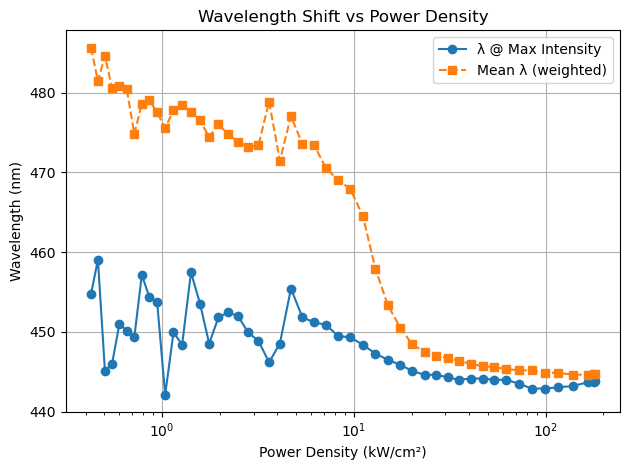

In [12]:
# ========== Analyse des décalages spectraux depuis "smoothed_data.txt" ==========

lambda_max_list = []
lambda_mean_list = []

for i in range(len(data_ASE)):
    intensities = Spectrum[:, i]
    wavelengths = Lambda

    lambda_max = wavelengths[np.argmax(intensities)]
    lambda_mean = np.sum(wavelengths * intensities) / np.sum(intensities)

    lambda_max_list.append(lambda_max)
    lambda_mean_list.append(lambda_mean)

lambda_max_array = np.array(lambda_max_list)
lambda_mean_array = np.array(lambda_mean_list)

# ========== Sauvegarde des données ==========
wavelengths_file = os.path.join(results_dir, 'wavelength_shifts.txt')
np.savetxt(
    wavelengths_file,
    np.column_stack((
        EnergyDensity_microJoules_per_cm2,
        PowerDensity / 1000,
        lambda_max_array,
        lambda_mean_array
    )),
    header='Absorbed Energy density (µJ/cm²)    Power Density (kW/cm²)    Lambda_max (nm)    Lambda_mean (nm)'
)

# ========== Tracé : en fonction de l’énergie absorbée ==========
plt.figure()
plt.semilogx(EnergyDensity_microJoules_per_cm2, lambda_max_array, 'o-', label='λ @ Max Intensity')
plt.semilogx(EnergyDensity_microJoules_per_cm2, lambda_mean_array, 's--', label='Mean λ (weighted)')
plt.xlabel('Absorbed Energy Density (µJ/cm²)')
plt.ylabel('Wavelength (nm)')
plt.title('Wavelength Shift vs Absorbed Energy Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'wavelength_vs_energy.png'), dpi=300)
plt.close()

# ========== Tracé : en fonction de la densité de puissance ==========
plt.figure()
plt.semilogx(PowerDensity / 1000, lambda_max_array, 'o-', label='λ @ Max Intensity')
plt.semilogx(PowerDensity / 1000, lambda_mean_array, 's--', label='Mean λ (weighted)')
plt.xlabel('Power Density (kW/cm²)')
plt.ylabel('Wavelength (nm)')
plt.title('Wavelength Shift vs Power Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'wavelength_vs_power.png'), dpi=300)
plt.show()

# Enregistrement des métadonnées nécéssaires

In [14]:
# ========== Sauvegarde des métadonnées de l’expérience (finale) ==========

metadata_file = os.path.join(results_dir, 'metadata.txt')
sample_name = str(Manual_Data[0])  # Première cellule = nom du sample

with open(metadata_file, 'w') as f:
    f.write("========== ASE Experiment Metadata ==========\n")
    f.write(f"Sample Name:                    {sample_name}\n")
    f.write(f"Pump Wavelength:                {PumpWavelength * 1e9:.1f} nm\n")
    f.write(f"Pump Pulse Duration:            {PulseDuration * 1e9:.1f} ns\n")
    f.write(f"Stripe Length (L):              {L_stripe * 1e4:.2f} µm\n")
    f.write(f"Stripe Width (e):               {e_stripe * 1e4:.2f} µm\n")
    f.write(f"Absorption Factor (%):              {Absorption *100:.1f}\n")
    f.write("\n")
    f.write("---------- Pump Energy Info ----------\n")
    f.write(f"Incident Pump Energies (nJ):    {Measured_Incident_Energy_nanojoules.round(2).tolist()}\n")
    f.write(f"OD (Pump energy correction):    {ODs.round(2).tolist()}\n")
    f.write(f"OD (Spectro correction):        {Ods_spectro.round(2).tolist()}\n")
    f.write("\n")
    f.write(f"Repetition Rate (Hz):           {Repetition_rate[0]}\n")
    f.write(f"Integration Times (s):          {Integration_Time_ASE.round(3).tolist()}\n")
    f.write("\n")
    f.write("Generated on:                   " + pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S') + "\n")